In [1]:
# this cell imports the libraries or packages that you can use during this assignment
# you are not allowed to import additional libraries or packages

from helpers import *
import os
import itertools
import numpy as np
import pandas as pd

# Machine Learning and Decomposition
from sklearn.decomposition import PCA, FastICA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import skfuzzy as fuzz

# Statistical tools
from scipy.stats import multivariate_normal
from scipy import linalg

# Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap, LogNorm
import seaborn as sns

> **Important**
>
> Do not import any other packages or libraries than the ones already provided to you. You can only use the imported packages _after_ they have been imported.
>
> Write your code between the `BEGIN_TODO` and `END_TODO` markers. Do not change these markers.
>
> Restart your notebook and run all cells before submission.

# Assignment 1a

## Introduction
In this assignment you will carry on data collection and preprocessing tasks, After collecting and preprocessing sensor recording, you will extract a set of features which you will use for creating the biking lane detector in assignment 1b.

This assignment is split into 4 parts. Parts 1-3 encompass the collection, preprocessing and feature extraction of sensor recordings. In part 4 you will employ PCA and ICA for data compression.

### Learning goals
After this assignment you can
- collect data according to a protocol;
- load and merge datasets;
- preprocess data;
- extract features from data;
- Perform data compression

## Part 1: Data collection

Collect the data according to the data collection protocol provided on Canvas.

## Part 2: Data cleaning and preprocessing
In this part you will be working on cleaning and preprocessing the overall data that each group have gathered for further analysis.


---
---
### Exercise 2.1: Read, merge and select data
Place your recordings in folder titled Data, inside the folder, create two folders, Bumpy folder and smooth folder, Load one of your individuals recordings from either folders in a Pandas DataFrame called `data`. You may want to have a look at the `pd.merge_asof` function to combine the recordings of the different sensors. Make sure that the `data` dataframe does not contain any `NaN`'s or empty fields as a result of different sampling frequencies. Any columns/recordings that you will not be using in your experiment should be removed from `data` (except for the `seconds_elapsed` column). Also remove duplicate colums. In the end your dataframe should have an indexing column, a column called `seconds_elapsed`, followed by the columns corresponding to the measurements.

In [2]:
#// BEGIN_TODO  Read, merge and select data

# read csvs from all three sensors
accel = pd.read_csv("data/bumpy/b1_k/Accelerometer.csv")
grav = pd.read_csv("data/bumpy/b1_k/Gravity.csv")
gyro = pd.read_csv("data/bumpy/b1_k/Gyroscope.csv")

# merge into one csv
data = pd.merge_asof(accel, grav, on="time")
data = pd.merge_asof(data, gyro, on="time")

data = data.reset_index()

# rename columns
data.rename(columns={"z_x": "z_a", "y_x": "y_a", "x_x":"x_a"}, inplace=True)
data.rename(columns={"z_y": "z_gr", "y_y": "y_gr", "x_y":"x_gr"}, inplace=True)
data.rename(columns={"z": "z_gy", "y": "y_gy", "x":"x_gy"}, inplace=True)

# remove duplicate columns
data.drop(columns=['seconds_elapsed_y', 'seconds_elapsed', 'time'], inplace=True)
data.rename(columns={"seconds_elapsed_x":"seconds_elapsed"}, inplace=True)


# check for NaN's
#data.isnull().sum().sum()


#// END_TODO 

In [3]:
data.shape

(6248, 11)

In [4]:
data.head()

,index,seconds_elapsed,z_a,y_a,x_a,z_gr,y_gr,x_gr,z_gy,y_gy,x_gy
0,0,0.022344,2.792245,-0.688192,1.671432,-7.878726,-5.693852,-1.294645,1.557297,-0.186077,-2.140898
1,1,0.032297,2.755034,0.061982,0.823451,-7.999683,-5.495024,-1.407187,1.833890,-0.402475,-2.198089
2,2,0.042250,0.725624,-0.510342,0.038250,-8.085699,-5.328068,-1.550338,1.402309,-0.761742,-1.306647
3,3,0.052203,-3.765084,-1.864201,-1.942126,-8.116890,-5.249271,-1.652767,0.254445,-0.811371,-0.374126
4,4,0.062156,-5.699907,0.171185,-5.689179,-8.100270,-5.251681,-1.725065,-0.482263,-1.175033,0.346571


### End of exercise 2.1
---
---

In order to restrict our focus to bumpy lane detection, we would like to trim the recorded segment. In this way we can remove the movements corresponding to starting and stopping the sensor logger app. 

---
---
### Exercise 2.2: Trim data
Remove the first and last 5 seconds of the recordings for this purpose and save this trimmed data frame to `data_trimmed`. Make sure that your code works for a data frame containing an arbitrary number of columns.

In [5]:
#// BEGIN_TODO Trim data

data_trimmed = data[data["seconds_elapsed"] >=5]
max_sec = data["seconds_elapsed"].max()
data_trimmed = data_trimmed[data_trimmed["seconds_elapsed"] <=(max_sec-5)]

#// END_TODO 

In [6]:
data_trimmed.shape

(5244, 11)

In [7]:
data_trimmed.head()

,index,seconds_elapsed,z_a,y_a,x_a,z_gr,y_gr,x_gr,z_gy,y_gy,x_gy
501,501,5.008840,-0.020685,-1.277896,0.824942,-1.367353,9.464120,-2.175122,-0.173298,-0.144292,0.277586
502,502,5.018793,0.431032,-1.775642,0.591827,-1.387515,9.457138,-2.192650,-0.146820,-0.157048,0.225531
503,503,5.028746,0.907879,-1.026438,0.888246,-1.401384,9.451334,-2.208797,-0.135794,-0.267545,0.141303
504,504,5.038699,1.077003,0.067041,1.181440,-1.403961,9.446618,-2.227257,-0.170364,-0.291149,0.060287
505,505,5.048653,1.209203,0.127264,0.563510,-1.405378,9.441462,-2.248130,-0.212377,-0.183154,0.094755


### End of exercise 2.2
---
---

---
---
### Exercise 2.3: Normalize recordings
For improved processing, the recordings should be normalized. Normalize the recordings by subtracting its mean and by then dividing by its standard deviation. Perform this normalization for each column individually. Save your normalized data in the the data frame `data_norm`.

In [8]:
#// BEGIN_TODO Normalize recordings


data_norm = data_trimmed.copy()
col_norm = ['z_a', 'y_a', 'x_a', 'z_gr', 'y_gr', 'x_gr', 'z_gy', 'y_gy', 'x_gy']
data_norm[col_norm] = (data_norm[col_norm] - data_norm[col_norm].mean()) / data_norm[col_norm].std()
#// END_TODO 

In [9]:
data_norm.shape

(5244, 11)

In [10]:
data_norm.head()

,index,seconds_elapsed,z_a,y_a,x_a,z_gr,y_gr,x_gr,z_gy,y_gy,x_gy
501,501,5.008840,-0.078366,-0.790585,0.732031,0.999339,1.468486,1.859420,-0.393993,-0.410573,0.672774
502,502,5.018793,0.370336,-1.084364,0.520691,0.963672,1.451131,1.835869,-0.331066,-0.449691,0.546365
503,503,5.028746,0.844000,-0.642169,0.789421,0.939137,1.436706,1.814172,-0.304861,-0.788547,0.341827
504,504,5.038699,1.011995,0.003223,1.055226,0.934578,1.424985,1.789368,-0.387022,-0.860930,0.145090
505,505,5.048653,1.143312,0.038768,0.495020,0.932072,1.412168,1.761322,-0.486868,-0.529749,0.228791


### End of exercise 2.3
---
---

In [11]:
# plot recordings
#ex2_plot_data(data_norm)

## Part 3: Feature extraction
The current data is not yet suited for building the detector. Based on the measurements at a specific point of time, it is difficult to determine whether the bike lane is smooth or bumpy. Instead, it would be more appropriate to perform the detection over _segments_ of time. In this part you will extract features that will be used for the detection. First all collected datasets will be processed.

---
---
### Exercise 3.1: Merge all datasets
Before starting the feature extraction, merge all the preprocessed datasets obtained in the protocol. You will need to load all recording, and again perform all preprocessing steps of Part 2 for the individual recordings. Make sure your code adheres to proper coding standards (make it look nice, don't copy part 2 15 times). Save your merged data in the the data frame `data_merged`, in addition, save merged data of bumpy lanes as `data_bumpy` and data of smooth lanes as `data_smooth`.

In [45]:
#// BEGIN_TODO Normalize recordings

# Function to merge accelerometer, gravity, and gyroscope data using merge_asof in a dataframe
def merge_sensor_data(accel, grav, gyro):
    # Merge accelerometer, gravity, and gyroscope on the 'time' column
    data = pd.merge_asof(accel, grav, on="time")
    data = pd.merge_asof(data, gyro, on="time")
    
    # Reset index for the combined DataFrame
    # data = data.reset_index()
    
    # Rename columns according to sensor types
    data.rename(columns={"z_x": "z_a", "y_x": "y_a", "x_x": "x_a"}, inplace=True)
    data.rename(columns={"z_y": "z_gr", "y_y": "y_gr", "x_y": "x_gr"}, inplace=True)
    data.rename(columns={"z": "z_gy", "y": "y_gy", "x": "x_gy"}, inplace=True)
    
    # Drop unnecessary or duplicate columns
    data.drop(columns=['seconds_elapsed_y', 'seconds_elapsed', 'time'], inplace=True)
    data.rename(columns={"seconds_elapsed_x": "seconds_elapsed"}, inplace=True)
    
    return data

# Function to trim the data
def trim_data(data):
    data_trimmed = data[data["seconds_elapsed"] >= 5]
    max_sec = data["seconds_elapsed"].max()
    data_trimmed = data_trimmed[data_trimmed["seconds_elapsed"] <= (max_sec - 5)]
    return data_trimmed


def norm_data(data):
    data_norm = data
    col_norm = ['z_a', 'y_a', 'x_a', 'z_gr', 'y_gr', 'x_gr', 'z_gy', 'y_gy', 'x_gy']
    data_norm[col_norm] = (data_norm[col_norm] - data_norm[col_norm].mean()) / data_norm[col_norm].std()
    return data_norm

# Define the root directory, path types, student names, and file names
root_path = "data/"
path_types = ['b', 's']  # 'b' for bumpy, 's' for smooth
student_names = ['k', 'I', 'j']
file_names = ['Accelerometer', 'Gravity', 'Gyroscope']

# Initialize a dictionary to store DataFrames for each folder
dataframes = {}

# Loop through each combination of path types (bumpy/smooth), folders (b1 to b5/s1 to s5), and students
for path_type in path_types:
    for i in range(1, 6):  # loop 1 to 5 
        for student in student_names:
            # Construct file paths for Accelerometer, Gravity, and Gyroscope CSV files
            folder_path = os.path.join(root_path, 
            'bumpy' if path_type == 'b' else 'smooth', 
            f'{path_type}{i}_{student}')
            accel_file = os.path.join(folder_path, 'Accelerometer.csv')
            grav_file = os.path.join(folder_path, 'Gravity.csv')
            gyro_file = os.path.join(folder_path, 'Gyroscope.csv')
            
            
            # Read the CSV files into DataFrames
            accel = pd.read_csv(accel_file)
            grav = pd.read_csv(grav_file)
            gyro = pd.read_csv(gyro_file)
            
            # Merge the sensor data 
            merged_data=merge_sensor_data(accel, grav, gyro)

            #trim the data 
            data_trimmed=trim_data(merged_data)

            #normalize the data
            data_norm=norm_data(data_trimmed)
            

            dataframes[f"{path_type}{i}_{student}"] = data_norm


# Initialize empty lists to store DataFrames for bumpy and smooth paths
bumpy_list = []
smooth_list = []

# Loop through the dataframes dictionary
for key, df in dataframes.items():
    if key.startswith('b'):  # If the key starts with 'b', it belongs to bumpy data
        bumpy_list.append(df)
    elif key.startswith('s'):  # If the key starts with 's', it belongs to smooth data
        smooth_list.append(df)

# Concatenate the DataFrames in each list to create a single DataFrame for bumpy and smooth
data_bumpy = pd.concat(bumpy_list, ignore_index=True)
data_smooth = pd.concat(smooth_list, ignore_index=True)

#all data merged
data_merged = pd.concat([data_bumpy, data_smooth], ignore_index=True)

#// END_TODO 

In [46]:
data_merged.shape

(72088, 10)

In [47]:
data_bumpy.shape

(38524, 10)

In [48]:
data_smooth.shape

(33564, 10)

In [49]:
data_merged.head()

,seconds_elapsed,z_a,y_a,x_a,z_gr,y_gr,x_gr,z_gy,y_gy,x_gy
0,5.008840,-0.078366,-0.790585,0.732031,0.999339,1.468486,1.859420,-0.393993,-0.410573,0.672774
1,5.018793,0.370336,-1.084364,0.520691,0.963672,1.451131,1.835869,-0.331066,-0.449691,0.546365
2,5.028746,0.844000,-0.642169,0.789421,0.939137,1.436706,1.814172,-0.304861,-0.788547,0.341827
3,5.038699,1.011995,0.003223,1.055226,0.934578,1.424985,1.789368,-0.387022,-0.860930,0.145090
4,5.048653,1.143312,0.038768,0.495020,0.932072,1.412168,1.761322,-0.486868,-0.529749,0.228791


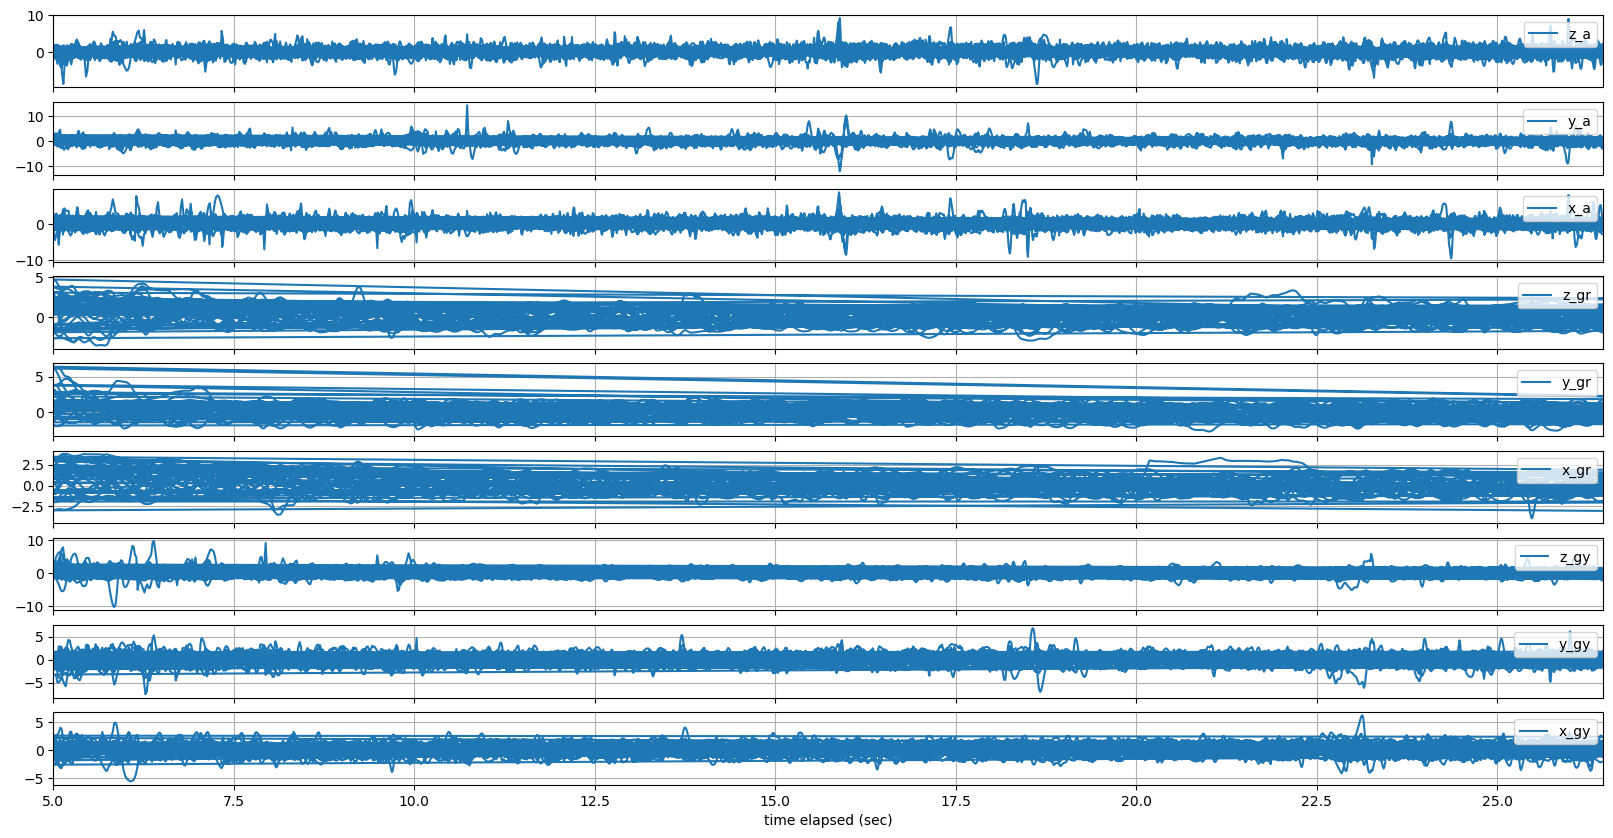

In [50]:
# plot recordings of data_merged
from helpers.analysis import ex2_plot_data
ex2_plot_data(data_merged)

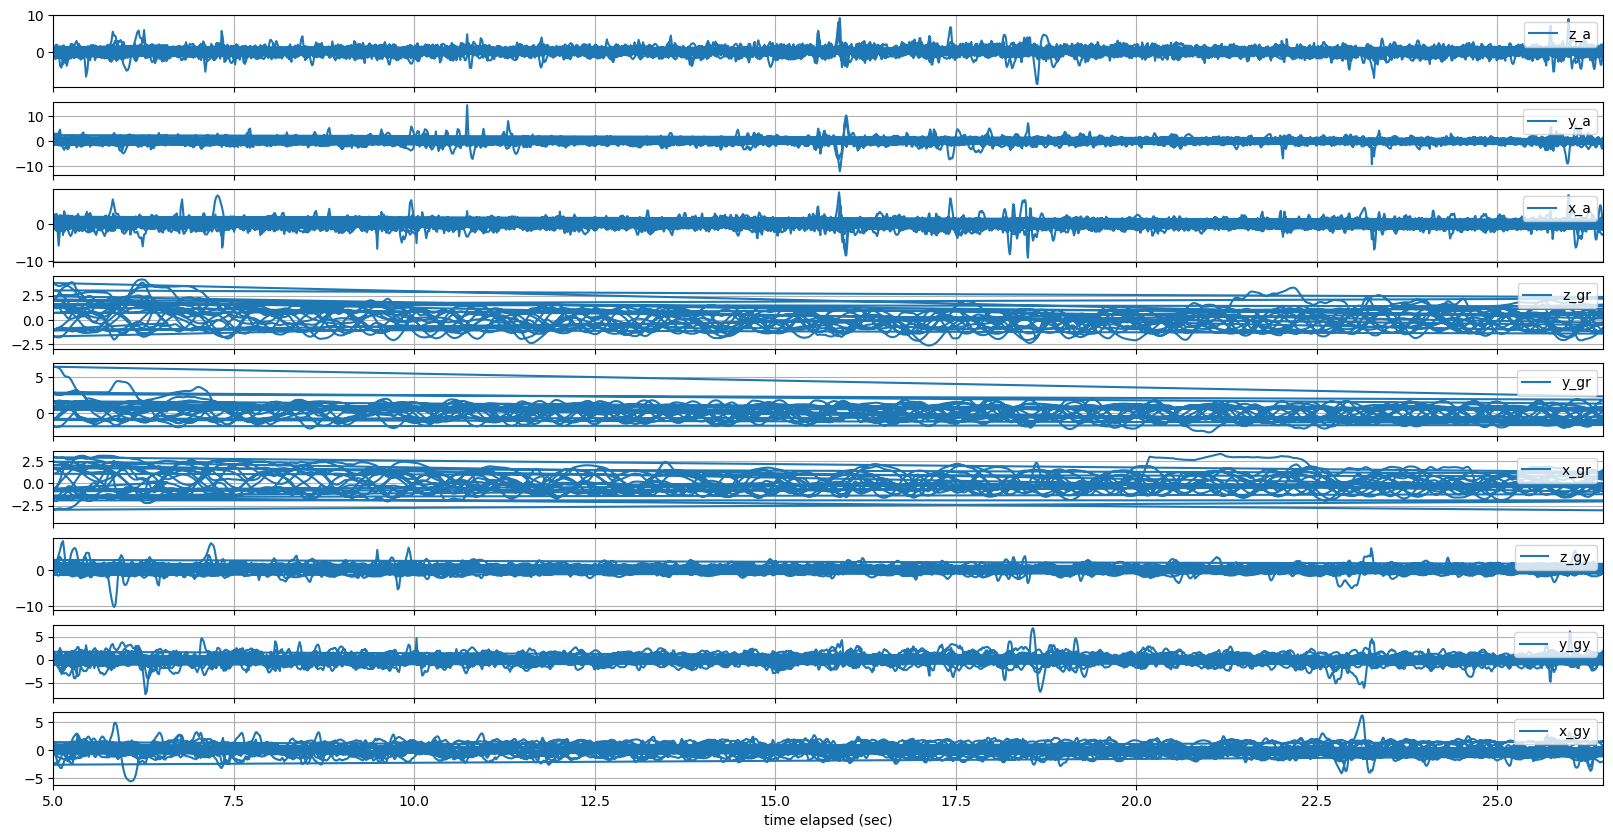

In [51]:
# plot recordings of data_smooth
ex2_plot_data(data_smooth)

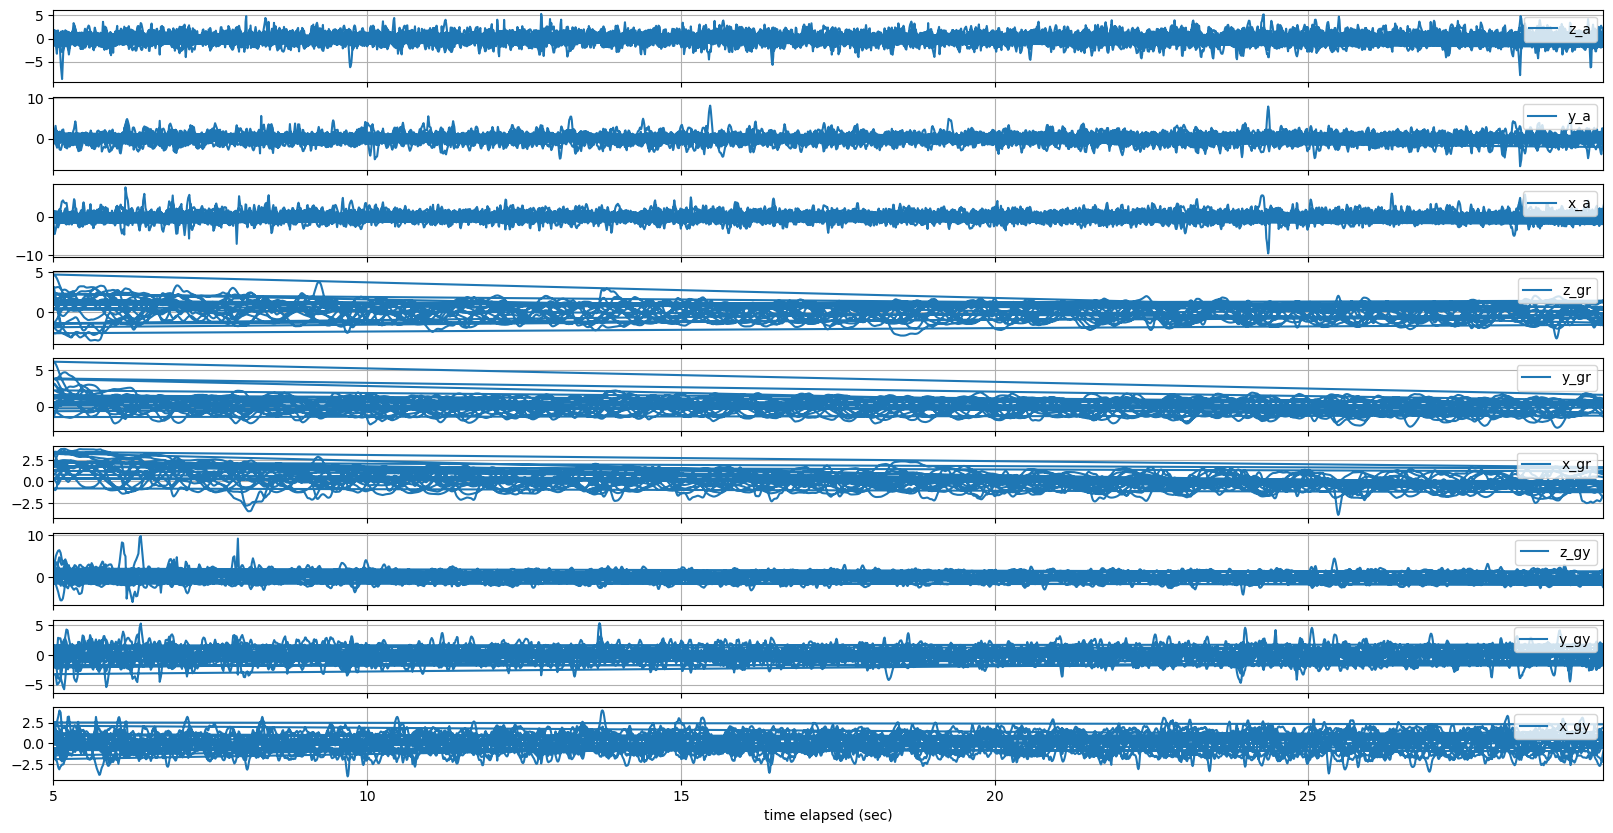

In [19]:
# plot recordings of data_bumpy
ex2_plot_data(data_bumpy)

### End of exercise 3.1
---
---

---
---
### Exercise 3.2: Convert dataframe to matrix
In order to extract features from the recordings, convert the dataframe `data_merged` to a Numpy matrix called `mat_merged`. The matrix should have dimensions (_nr of time points_, _nr or different recordings_). Make sure that you remove the _seconds_elapsed_ column, as this does not yield any useful information for the ;ane detector.

In [20]:
#// BEGIN_TODO  Convert to matrix

#remove seconds from dataframe 
data_merged=data_merged.drop(columns=['seconds_elapsed'])

#convert to numpy matrix 
mat_merged = np.matrix(data_merged)

#// END_TODO 

### End of exercise 3.2
---
---

Now that the dataframe has been converted to a matrix, it can be split into different overlapping segments, of which we can extract features.

As a starting point we will specify features as the mean value of a segment, its standard deviation, its minimum and its maximum.

---
---
### Exercise 3.3: Processing segments
Create a function `Y = process_segment(mat, fun, L, K)` that processes time segments of your matrix. The argument `fun` specifies the operation to be performed on the segment and its value comes from the set `["mean", "std", "minimum", "maximum"]`. `L` specifies the segment length and `K` specifies the number of samples overlap between segments. The function should return a matrix `Y` with dimensions (_nr of segments_, _nr of different recordings_).

In [21]:
#// BEGIN_TODO Process segments

#funciton to process the segmetns of the matrix
def process_segment(mat,fun,L,K):

    #define operations 
    operations={
        "mean": np.mean,
        "std": np.std,
        "minimum": np.min,
        "maximum": np.max
    }

    #calculate the number of segments 
    num_segments=(mat.shape[0]-L)//(L-K)+1
    num_recordings=(mat.shape[1])
    
    #Initialize result matrix Y 
    Y = np.zeros((num_segments, num_recordings))

    # Process each segment
    for i in range(num_segments):
        start = i * (L - K)
        end = start + L
        segment = mat[start:end, :]
        
        # Apply the specified function to the segment
        Y[i, :] = operations[fun](segment, axis=0)
    
    return Y



#// END_TODO 

In [22]:
Y_mean_1 = process_segment(mat_merged, "mean", 20, 10)
Y_std_1 = process_segment(mat_merged, "std", 20, 10)
Y_minimum_1 = process_segment(mat_merged, "minimum", 20, 10)
Y_maximum_1 = process_segment(mat_merged, "maximum", 20, 10)

### End of exercise 3.3
---
---

---
---
### Exercise 3.4: Concatenate features
Now that you have computed some features of the recordings, it becomes necessary to combine them. Create the matrix `combined_features` which concatenates the above results along the appropriate axis.


In [23]:
#// BEGIN_TODO Concatenate features

# Concatenate the feature matrices along the columns (axis=1)
combined_features = np.concatenate((Y_mean_1, Y_std_1, Y_minimum_1, Y_maximum_1), axis=1)
#// END_TODO 

### End of exercise 3.4
---
---

### Exercise 3.5: preprocessing smooth and bumpy dataframes
perform the same preprocessing steps on your smooth and bumpy dataframe. By the end of the exercise you should output two additional matrices; `smooth_features` and `bumpy_features`

In [54]:
#// BEGIN_TODO Concatenate features

#drop seconds elapsed 
data_smooth=data_smooth.drop(columns=['seconds_elapsed'])
data_bumpy=data_bumpy.drop(columns=['seconds_elapsed'])

#convert to numpy matrix 
mat_smooth = np.matrix(data_smooth)
mat_bumpy=np.matrix(data_bumpy)

#values for smooth
Y_mean_smooth = process_segment(mat_smooth, "mean", 20, 10)
Y_std_smooth = process_segment(mat_smooth, "std", 20, 10)
Y_minimum_smooth = process_segment(mat_smooth, "minimum", 20, 10)
Y_maximum_smooth = process_segment(mat_smooth, "maximum", 20, 10)

#values for bumpy
Y_mean_bumpy = process_segment(mat_bumpy, "mean", 20, 10)
Y_std_bumpy = process_segment(mat_bumpy, "std", 20, 10)
Y_minimum_bumpy = process_segment(mat_bumpy, "minimum", 20, 10)
Y_maximum_bumpy = process_segment(mat_bumpy, "maximum", 20, 10)

#eature output 
smooth_features = np.concatenate((Y_mean_smooth, Y_std_smooth, Y_minimum_smooth, Y_maximum_smooth), axis=1)
bumpy_features = np.concatenate((Y_mean_bumpy, Y_std_bumpy, Y_minimum_bumpy, Y_maximum_bumpy), axis=1)


#// END_TODO 

KeyError: "['seconds_elapsed'] not found in axis"

In [52]:
print("Dimensions of combined features:", combined_features.shape)
print("Dimensions of smooth features:", smooth_features.shape)
print("Dimensions of bumpy features:", bumpy_features.shape)

Dimensions of combined features: (7207, 36)
Dimensions of smooth features: (3355, 36)
Dimensions of bumpy features: (3851, 36)


array([[-0.49987287,  0.32780736,  0.29917305, ...,  0.0262364 ,
        -0.1011698 ,  0.74254569],
       [-0.65370088,  0.00935412,  0.37340638, ...,  0.0262364 ,
         0.66779241,  0.57470086],
       [-0.58799561, -0.25046007,  0.23225339, ..., -0.97112894,
         0.92390205,  1.50040885],
       ...,
       [-0.31731786, -0.26816052,  0.44304273, ...,  1.28326992,
         1.3809225 ,  1.88465895],
       [-0.34081918, -0.05212787,  0.2189095 , ...,  0.63975156,
         0.49788169,  1.17602241],
       [-0.20563767, -0.17783781,  0.20566234, ..., -0.09581228,
         0.49788169, -0.23733205]])

### End of exercise 3.5
---
---

## Part 4: Data Compression
In this part of the assignment you will implement the data compression techniques you have learned during the course.

## Part 4.1: Principal component analysis

Recorded data is often high-dimensional, leading to a large computational burden and limiting real-time data processing. Quite often we would therefore like to compress the data, such that it uses less memory. The creation of .zip-files on your computer is an example of data compression. In this part we will look at one method that achieves data compression, namely Principal component analysis (PCA). PCA is a useful technique for analyzing high-dimensional data, and compressing this data for storage or processing purposes. PCA aims to fit an orthogonal coordinate system to a dataset that best captures the variance or spread of the data. This approach is very closely related to the eigendecomposition of a matrix.

PCA aims to find the orthogonal directions of most variance of the dataset. Therefore it first computes the covariance matrix of the dataset, which can be estimated as
$$\Sigma = \mathrm{Cov}[{\bf{x}}] \approx \frac{1}{N-1} \sum_{n=1}^N ({\bf{x}}_n - \mathrm{E}[{\bf{x}}])({\bf{x}}_n - \mathrm{E}[{\bf{x}}])^\top,$$
where ${\bf{x}}_n$ is the $n$-th data sample and where $\mathrm{E}[{\bf{x}}]$ represents the expected value, or mean, which can be estimated as
$$\mathrm{E}[{\bf{x}}] \approx \frac{1}{N} \sum_{n=1}^N {\bf{x}}_n.$$
The covariance matrix captures the variances of the individual elements/features in ${\bf{x}}_n$ and the covariances between elements/features. 

Based on the obtained covariance matrix, you will perform an eigendecomposition. An eigenvalue decomposition finds a set of eigenvectors and corresponding eigenvalues. An eigenvector ${\bf{v}}$ and corresponding eigenvalue ${\lambda}$ of some square matrix $A$ satisfy the equation
$$A {\bf{v}} = \lambda {\bf{v}}.$$
In matrix notation, this can be written as
$$A Q = Q\Lambda,$$
where $Q$ is an orthonormal matrix where each column represents an eigenvector. Orthonormal refers to the individual eigenvectors being of unit length, and perpendicular to eachother. This matrix satisfies the useful properties $QQ^\top = Q^\top Q = I$ and $Q^\top = Q^{-1}$. $\Lambda$ is a diagonal matrix, whose diagonal contains the eigenvalues of $A$. The matrix $A$ can therefore be decomposed as 
$$A = Q\Lambda Q^\top$$

---
---
### Exercise 4.1: Compute eigenvalues and eigenvectors


Write a function `compute_eigen(X)` which computes the eigenvalues and eigenvectors of the covariance matrix of some toy dataset `X`. The dataset is a matrix of shape ($N\times M$), where $N$ denotes the number of data samples and $M$ the dimensionality of the features. The function should return a vector of length $M$ containing the eigenvalues and a matrix of shape ($M\times M$) containing the corresponding eigenvectors.

In [26]:
#// BEGIN_TODO Compute eigenvalues and eigenvectors
from numpy.linalg import eig
def compute_eigen(x):
    x_centered = x-np.mean(x, axis = 0)
    cov_matrix = np.cov(x_centered, rowvar= False) # rowvar = false every column represents a feature
    eigenvalues, eigenvectors = eig(cov_matrix)
    return eigenvalues, eigenvectors 
#// END_TODO 

(array([10.14351027,  1.04666349]),
 array([[ 0.8774665 ,  0.47963793],
        [-0.47963793,  0.8774665 ]]))

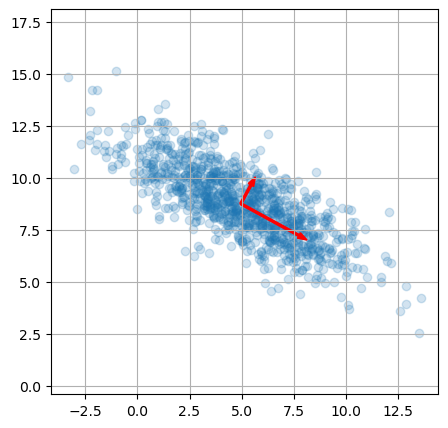

In [28]:
# generate data
from helpers.analysis import ex11_generate_data, plot_eigen
X = ex11_generate_data()

# compute eigenvalues and eigenvectors
eigvals, eigvecs = compute_eigen(X)

# plot data
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], alpha=0.2)
plot_eigen(np.mean(X, axis=0), eigvals, eigvecs, plt.gca(), width=0.1, color="r")
plt.axis("equal")
plt.grid()

# print eigenvalues and eigenvectors
eigvals, eigvecs

Have a look at the computed eigenvalues, eigenvectors and the visualization and answer the questions below:
- In what direction does the first eigenvector point?
- How can the eigenvalue be interpreted?

In [29]:
# 1st question
first_eigenvector = eigvecs[:, 0]
first_eigenvector

array([ 0.8774665 , -0.47963793])

`BEGIN_TODO Interpretation of eigenvalues and eigenvectors`

Answer: 

The first eigenvector points predominantly in the positive X direction and slightly in the negative Y direction. 

The eigenvalue represents the amount of variance captured by its corresponding eigenvector. A larger eigenvalue means that the eigenvector explains a grater proportion of the total variance in the dataset. For example, if one eigenvalue is much larger than the others, this indicates that the corresponding eigenvector represents a direction along which the data varies significantly more compared to other directions. 

`END_TODO `

### End of exercise 4.1
---
---

With the computed eigendecomposition, the original dataset can be transformed such that its new mean coincides with the origin (0,0) and that the new eigenvectors specify Euclidean standard basis vectors (i.e. the new covariance matrix is diagonal). The first step can be obtained by subtracting the mean from the dataset. The origin-centered dataset $\tilde{X}$ now is centered in the origin and therefore the covariance matrix can be estimated as 
$$ \tilde{\Sigma} = \mathrm{Cov}[\tilde{\bf{x}}] \approx \frac{1}{N-1} \tilde{X}^\top \tilde{X}\qquad\qquad \text{if }\mathrm{E}[\tilde{{\bf{x}}}] = {\bf{0}}$$
with the corresponding eigendecomposition $\tilde{\Sigma} = \tilde{Q} \tilde{\Lambda} \tilde{Q}^\top$.

If we multiply $\tilde{X}$ with $\tilde{Q}$ to get the transformed dataset $Y=\tilde{X}\tilde{Q}$, we observe that the new covariance matrix becomes
$$\mathrm{Cov}[{\bf{y}}] \approx \frac{1}{N-1} Y^\top Y = \frac{1}{N-1}\tilde{Q}^\top \tilde{X}^\top \tilde{X} \tilde{Q} = \tilde{Q}^\top\tilde{\Sigma}\tilde{Q} = \tilde{Q}^\top\tilde{Q} \tilde{\Lambda} \tilde{Q}^\top\tilde{Q} = \tilde{\Lambda},$$
which is diagonal.



---
---
### Exercise 4.2: Data transformation

Write a function `transform_PCA(X, mean, eigvecs)` which translates some dataset `X` to be centered in the origin, and rotates it, such that its new covariance matrix is diagonal. $X$ is of shape ($N\times M$), where $N$ denotes the number of data samples and $M$ the dimensionality of the features. The function should return the transformed dataset of shape ($N\times M$). Also create the function `inversetransform_PCA(X, mean, eigvecs)` which performs the inverse transform.

In [30]:
#// BEGIN_TODO Transform data to PCA space
def transform_PCA(x, mean, eigvecs): 
    X_centered = X - mean
    X_transformed = X_centered @ eigvecs # rotation
    return X_transformed
#// END_TODO 

In [31]:
#// BEGIN_TODO Transform data back from PCA space
def inversetransform_PCA(x, mean, eigvecs):
    X_centered = x @ eigvecs.T
    X_original = X_centered + mean
    return X_original    
#// END_TODO

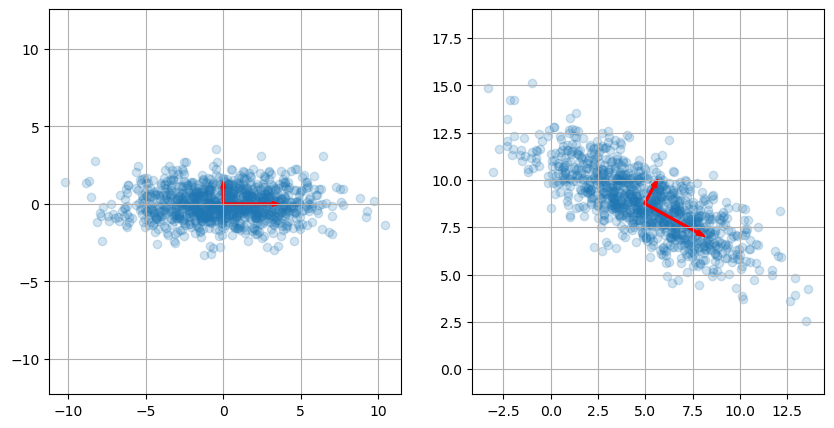

In [32]:
# transform data
m = np.mean(X, axis=0)
eigvals, eigvecs = compute_eigen(X)
Y = transform_PCA(X, m, eigvecs)
Z = inversetransform_PCA(Y, m, eigvecs)

# plot transformed data
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].scatter(Y[:,0], Y[:,1], alpha=0.2)
eigvalsY, eigvecsY = compute_eigen(Y)
plot_eigen(np.mean(Y, axis=0), eigvalsY, eigvecsY, ax[0], width=0.1, color="r")
ax[1].scatter(Z[:,0], Z[:,1], alpha=0.2)
eigvalsZ, eigvecsZ = compute_eigen(Z)
plot_eigen(np.mean(Z, axis=0), eigvalsZ, eigvecsZ, ax[1], width=0.1, color="r")
ax[0].axis("equal"), ax[1].axis("equal")
ax[0].grid(), ax[1].grid();

### End of exercise 4.2
---
---

So far PCA has only been discussed for a toy example. Let's now apply it to high-dimensional data. We will load a dataset containing 400 images of faces. These grayscale images are of size (64 $\times$ 64) and therefore contain 4096 pixels. In order to process the images, they have been flattened into vectors, which are appended to create a matrix containing 400 images. Below we have plotted the first 100 images:

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to data


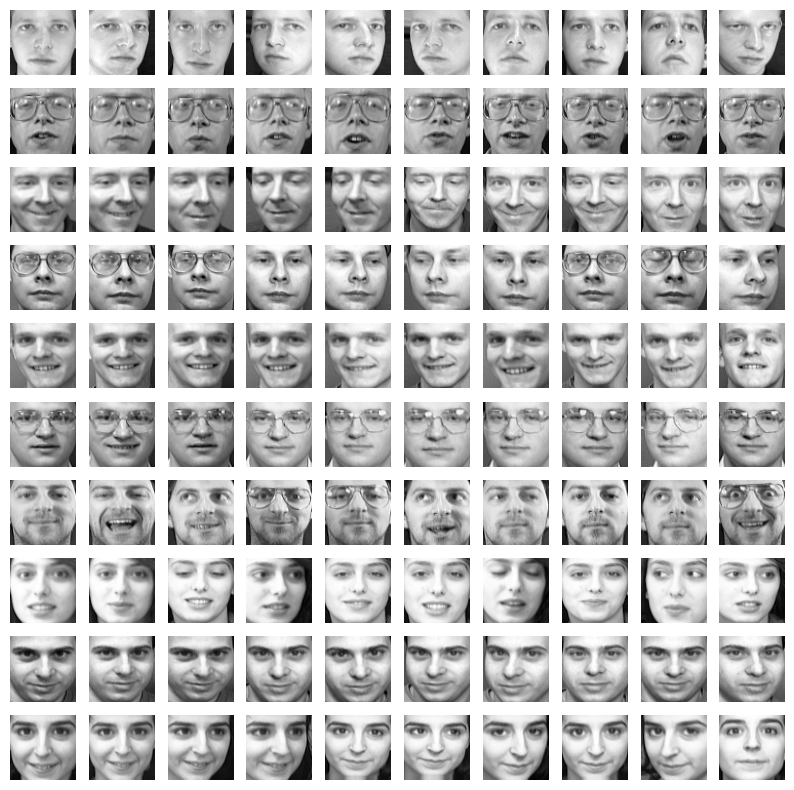

In [33]:
from helpers.analysis import ex13_generate_data, plot_faces
X = ex13_generate_data()
plot_faces(X)

---
---
### Exercise 4.3: Principal components analysis
Compute the eigenvalues and vectors of the faces dataset. Plot the first 350 eigenvalues with both a normal as log-scaling on the y-axis.

> Note: Since the dataset only contains 400 images, the covariance matrix of size (4096 $\times$ 4096) is not positive definite (although it should be in theory). Therefore the eigenvalues > 400 are basically useless, however, they are still computed as imaginary quantities. You can plot the real or absolute values of the eigenvalues.

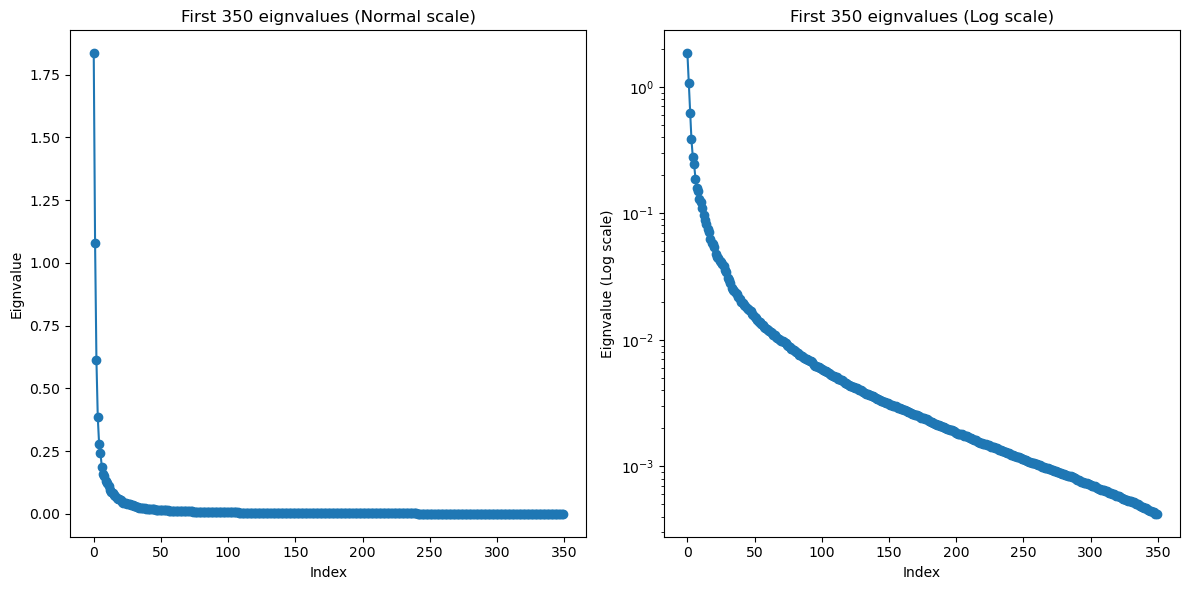

In [34]:
#// BEGIN_TODO Plot eigenvalues
mean = np.mean(X, axis=0)
X_centered = X - mean
cov_matrix = np.dot(X_centered, X_centered.T) / X_centered.shape[1] # np. dot --> matrix product between X_centered and its 
                                                                    # transpose (X_centered.T); X_centered.shape[1] --> divided 
                                                                    # by the number os columns
eigenvalues, eigenvectors = eig(cov_matrix)

sort = np.argsort(eigenvalues)[::-1] # descending order
eigenvalues = eigenvalues[sort]
eigenvectors = eigenvectors[:, sort]

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(eigenvalues[:350], marker='o')
plt.title('First 350 eignvalues (Normal scale)')
plt.xlabel('Index')
plt.ylabel('Eignvalue')

plt.subplot(1,2,2)
plt.plot(eigenvalues[:350], marker='o')
plt.yscale('log')
plt.title('First 350 eignvalues (Log scale)')
plt.xlabel('Index')
plt.ylabel('Eignvalue (Log scale)')
plt.tight_layout()

#// END_TODO 

Based on the created plots, what do you observe? How could this be useful for data compression?

`#// BEGIN_TODO  What do you observe?`

According to the normal scale plot, we can see that the eigenvalues are decreasing rapidly, with a small number of large eignvalues followed by many smaller ones. On the other hand, in the log scale plot, we can see that the decrease is less abrupt and clearer. The rapid decrease of the eignvalues indicates that most of the variance in data is captured by the first principal component. In other words, the majority of the information in the datset can be represented using only a small subset of the principal components. 

PCA can be highly effective for data compression, particularly when reduction of dimensionality. We can select only the principal components with the largest eigenvalues that capture most of the variance. This allows for compressed representation of the data, reducing the number of dimensions without losing much important information. 

`#// END_TODO`

### End of exercise 4.3
---
---

Now we will use PCA for data compression. Instead of performing the transform to the PCA space with the entire eigenvector matrix with shape (4096 $\times$ 4096), we only use the $K$ eigenvectors corresponding with the $K$ largest eigenvalues. 

---
---
### Exercise 4.4: Data compression
Compress the faces dataset using PCA in a matrix of shape (400 $\times$ $K$) and then decompress the data and plot the faces using the `plot_faces()` function. 

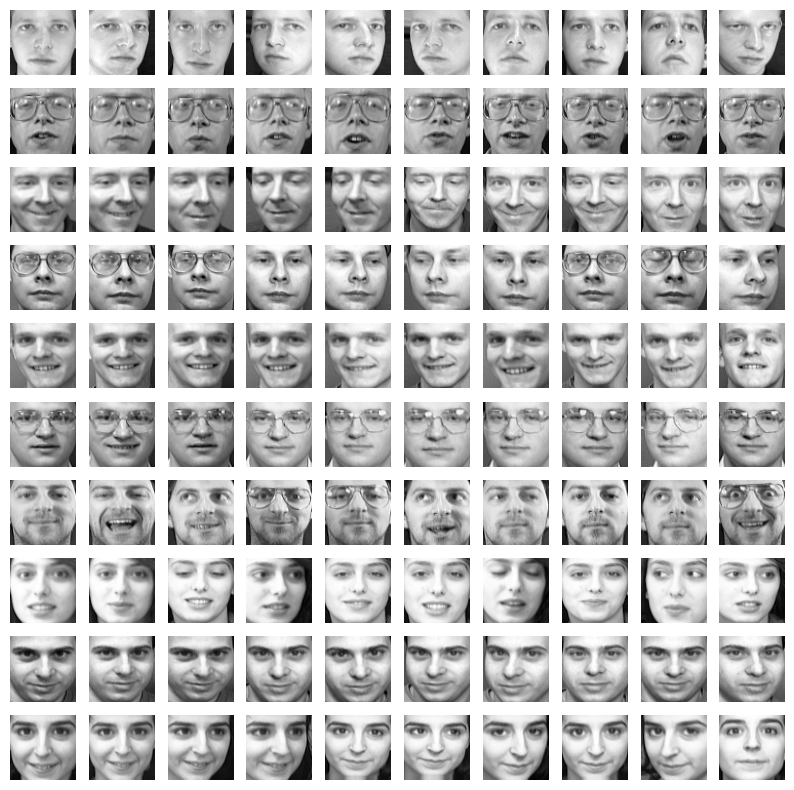

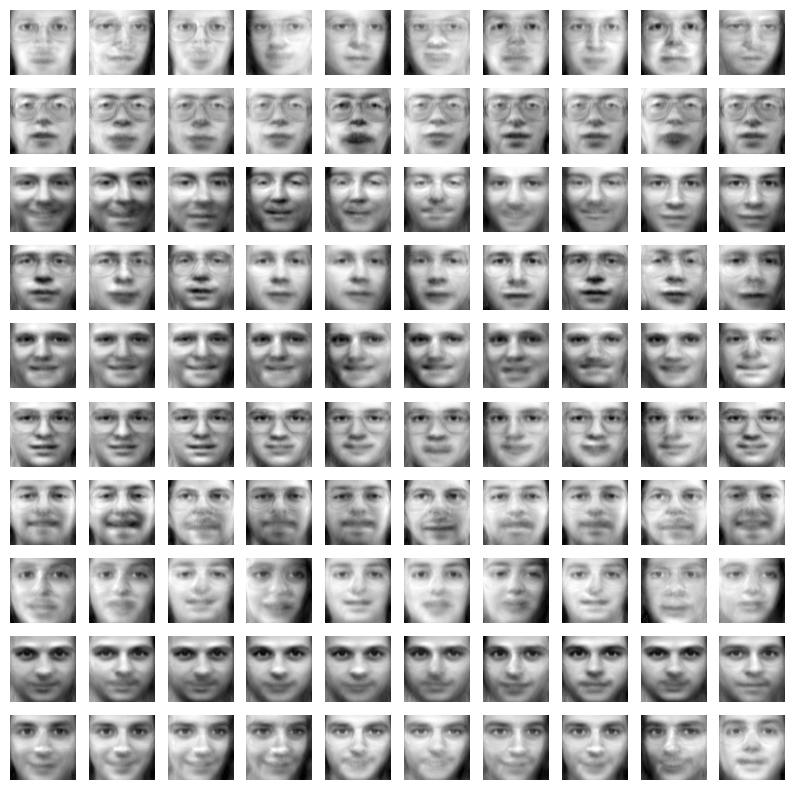

In [62]:
#// BEGIN_TODO Data compression
######CHANGE CODE 
from sklearn.decomposition import PCA

faces_data=ex13_generate_data()
# Step 2: Apply PCA to compress the dataset
K = 20  # Set the number of principal components to retain
pca = PCA(n_components=K)
compressed_faces = pca.fit_transform(faces_data)  # Compress

decompressed_faces = pca.inverse_transform(compressed_faces)

# Plot original faces
plot_faces(faces_data)

# Plot decompressed faces
plot_faces(decompressed_faces)



#// END_TODO

Analyze the results. What do you observe if you change $K$?

`#// BEGIN_TODO What do you observe?`


`#// END_TODO`

### End of exercise 4.4
---
---

---
---
### Exercise 4.5: PCA implementation on biking data
During this part you can make use of the sklearn (Scikit learn) package. This package offers some benefits over the handwritten clustering functions. These algorithms are numerically stable and better optimized to run on large data sets. choose 2 principal components for this exercise. Store the compressed data of combined_features as pca_combined, store the compressed data for smooth_features as pca_smooth, store the compressed data for bumpy features as pca_bumpy.

In [35]:
#// BEGIN_TODO PCA with sklearn
pca = PCA(n_components=2)
pca_combined = pca.fit_transform(combined_features)
pca_smooth = pca.fit_transform(smooth_features)
pca_bumpy = pca.fit_transform (bumpy_features)
#// END_TODO 

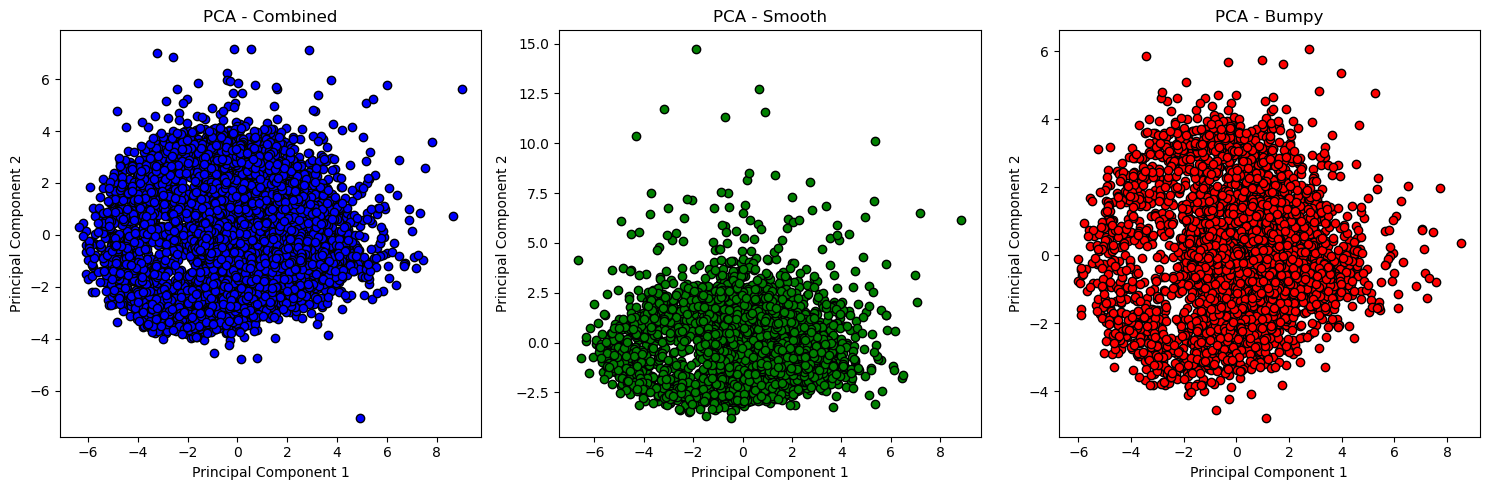

In [36]:
# Create a figure with 3 subplots in a single row
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot PCA for combined features
axs[0].scatter(pca_combined[:, 0], pca_combined[:, 1], c='blue', edgecolor='k')
axs[0].set_title('PCA - Combined')
axs[0].set_xlabel('Principal Component 1')
axs[0].set_ylabel('Principal Component 2')

# Plot PCA for smooth features
axs[1].scatter(pca_smooth[:, 0], pca_smooth[:, 1], c='green', edgecolor='k')
axs[1].set_title('PCA - Smooth')
axs[1].set_xlabel('Principal Component 1')
axs[1].set_ylabel('Principal Component 2')

# Plot PCA for bumpy features
axs[2].scatter(pca_bumpy[:, 0], pca_bumpy[:, 1], c='red', edgecolor='k')
axs[2].set_title('PCA - Bumpy')
axs[2].set_xlabel('Principal Component 1')
axs[2].set_ylabel('Principal Component 2')

# Adjust layout so plots don’t overlap
plt.tight_layout()

# Show the plots
plt.show()


Although we are choosing 2 components, how many principal components would you consider? Justify your answer quantitatively and qualitatively.

`#// BEGIN_TODO  PCA with sklearn/qualitative`


`#// END_TODO`

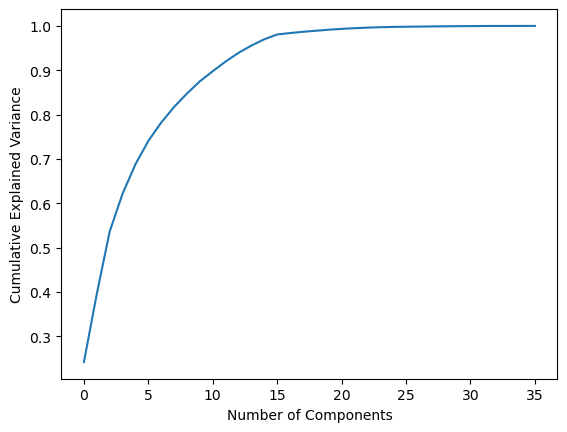

In [37]:
#// BEGIN_TODO  PCA with sklearn/quantitative
pca = PCA().fit(combined_features)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()
#// END_TODO

### End of exercise 4.5
---
---

## Part 4.2: Independent component analysis

Another approach of finding the most important components in a dataset is independent component analysis (ICA). Below you will use it to analyze a toy data set.

---
---
### Exercise 4.6: Limitations PCA
Have a look at the dataset below. Would PCA be a good approach for finding the components of highest variance? Please motivate your answer.

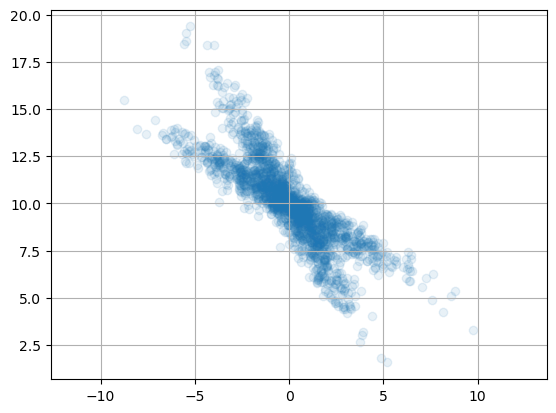

In [39]:
from helpers.analysis import ex21_generate_data
X = ex21_generate_data()
plt.scatter(X[:,0], X[:,1], alpha=0.1)
plt.grid(True)
plt.axis("equal");

`#// BEGIN_TODO Limitations PCA`


`#// END_TODO`

### End of exercise 4.6
---
---

> Note: From this moment onwards you can use the `FastICA` function from `sklearn`.

---
---
### Exercise 4.7: PCA versus ICA
Use the `PCA` and `FastICA` functions from `sklearn` to create the objects `pca_object` and `ica_object`, each with two components. Fit these objects to the dataset and transform the dataset. Save the transformed dataset into the variables `data_transformed_pca` and `data_transformed_ica`.

In [ ]:
#// BEGIN_TODO PCA and ICA




#// END_TODO

In [ ]:
_, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].scatter(X[:,0], X[:,1], alpha=0.1)
ax[1].scatter(data_transformed_pca[:,0], data_transformed_pca[:,1], alpha=0.1)
ax[2].scatter(data_transformed_ica[:,0], data_transformed_ica[:,1], alpha=0.1)
plot_pca(ax[0], pca_object, np.mean(X, axis=0))
plot_ica(ax[0], ica_object, np.mean(X, axis=0))
ax[0].grid(True), ax[1].grid(True), ax[2].grid(True)
ax[0].axis('equal'), ax[1].axis('equal'), ax[2].axis('equal')
ax[0].set_title("original data"), ax[1].set_title("transformed data (PCA)"), ax[2].set_title("transformed data (ICA)");

Run your code a couple of times. What do you observe? Which method works best for this data set?

`#// BEGIN_TODO PCA versus ICA`


`#// END_TODO`

### End of exercise 4.7
---
---

> Make sure to restart this notebook and to rerun all cells before submission to check whether all code runs properly.

# End of Assignment 1a

---
---
---